# Calculations for PV Global installs, c-Si Marketshare

This journal documents the manipulation of PV installation data for Global installs. This covers selection of data, and weighting by marketshare.

In [ ]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})
plt.rcParams['figure.figsize'] = (30, 15)

cwd = os.getcwd() #grabs current working directory

supportMatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

In [ ]:
cwd = os.getcwd() #grabs current working directory
df_installs_raw = pd.read_csv(os.path.join(supportMatfolder,'PVInstalls_World_AllSources.csv'), index_col='Year')
sources = df_installs_raw.columns
print(len(sources))

In [ ]:
plt.plot(df_installs_raw.index,df_installs_raw[sources[0]],lw=4,marker='*',label=sources[0])
plt.plot(df_installs_raw.index,df_installs_raw[sources[1]],lw=3,marker='o',label=sources[1])
plt.plot(df_installs_raw.index,df_installs_raw[sources[2]],lw=2,marker='o',label=sources[2])
plt.plot(df_installs_raw.index,df_installs_raw[sources[3]],lw=2,marker='o',label=sources[3])

plt.yscale('log')
plt.ylabel('PV Installed (MW)')
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
#plt.plot(df_installs_raw, marker='o')

# Select the data to use for installs

Based on the above graph, we will utilize Goetzberger data through 2000, then IRENA online query tool after 2000.

In [ ]:
#Before 2000 = Goetz
installs_old = df_installs_raw.loc[(df_installs_raw.index<=2000) & (df_installs_raw.index>=1995)]
installs_old_Goetz = pd.DataFrame(installs_old[sources[3]])
installs_old_Goetz.columns = ['installed_pv_MW']

#After 2000 = IRENA
installs_recent = df_installs_raw.loc[(df_installs_raw.index>2000) & (df_installs_raw.index<2020)]
installs_recent_IRENA = pd.DataFrame(installs_recent[sources[0]])
installs_recent_IRENA.columns = ['installed_pv_MW']
#print(installs_recent_IRENA)

### Collect the installation data together into a single df

In [ ]:
installs = pd.concat([installs_old_Goetz,installs_recent_IRENA])
plt.plot(installs)
plt.yscale('log')
plt.title('Installations of PV Globally (MW) since 1995')

# Marketshare weight the installation data for percent of Silicon vs Thin Film

In addition to compiling a single installation record for 1995 through the present, this data is total cumulative, but the tool it currently considering crystalline silicon technology only (i.e. mono and multi, but not ribbon or amorphous).

In [9]:
cwd = os.getcwd() #grabs current working directory
df_raw_mrktshr_siVtf = pd.read_csv(os.path.join(supportMatfolder,'MarketShare_global_c-SiVSthinfilm.csv'), index_col='Year')
refs = df_raw_mrktshr_siVtf.columns
print(len(refs))

4


(50.0, 100.0)

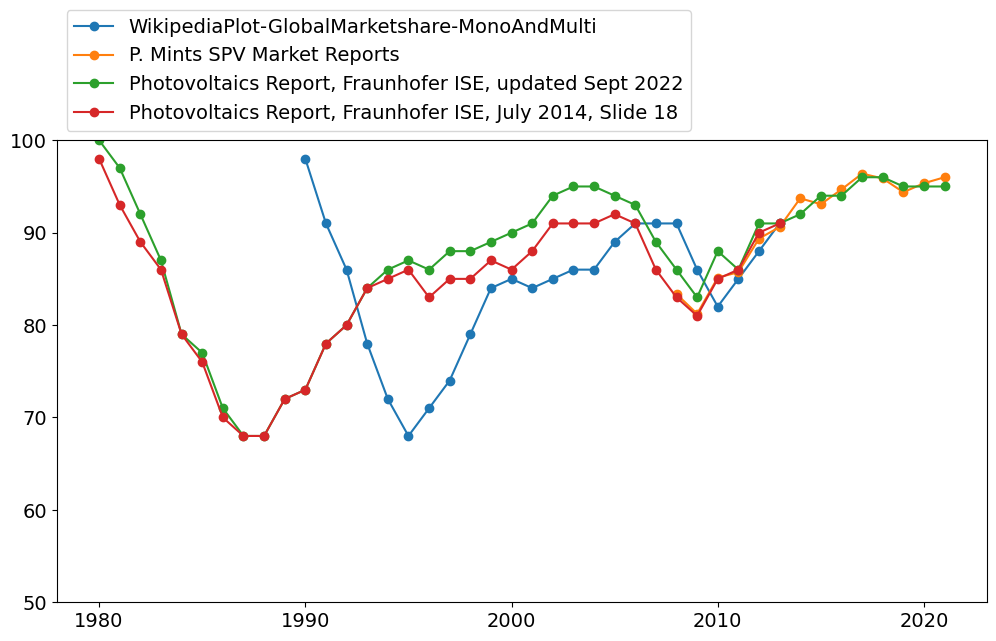

In [10]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[0]],marker='o',label=refs[0])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[1]],marker='o',label=refs[1])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[2]],marker='o',label=refs[2])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[3]],marker='o',label=refs[3])
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.ylim(50,100)

The 2020 Fraunhofer and 2014 Fraunhofer appear to agree reasonably closely, and Mints agrees closely for the amount of time there is overlap. The unknown sourced wikipedia figure doesn't agree until 2010, but given the unknown source, it will be discarded. We will use the Fraunhofer ISE 2020 market share data for the entire time period.

In [11]:
refs

Index(['WikipediaPlot-GlobalMarketshare-MonoAndMulti',
       'P. Mints SPV Market Reports',
       'Photovoltaics Report, Fraunhofer ISE, updated Sept 2022',
       'Photovoltaics Report, Fraunhofer ISE, July 2014, Slide 18'],
      dtype='object')

In [12]:
df_mrktshr_global =  pd.DataFrame(df_raw_mrktshr_siVtf[refs[2]]) #select Fraunhofer for historical 1995-2020
mrktshr_global = df_mrktshr_global.loc[(df_mrktshr_global.index>=1995)]
# use PMints for most recent data
mrktshr_global.columns = ['Global_MarketShare']
#print(mrktshr_global)

(0.0, 1.1)

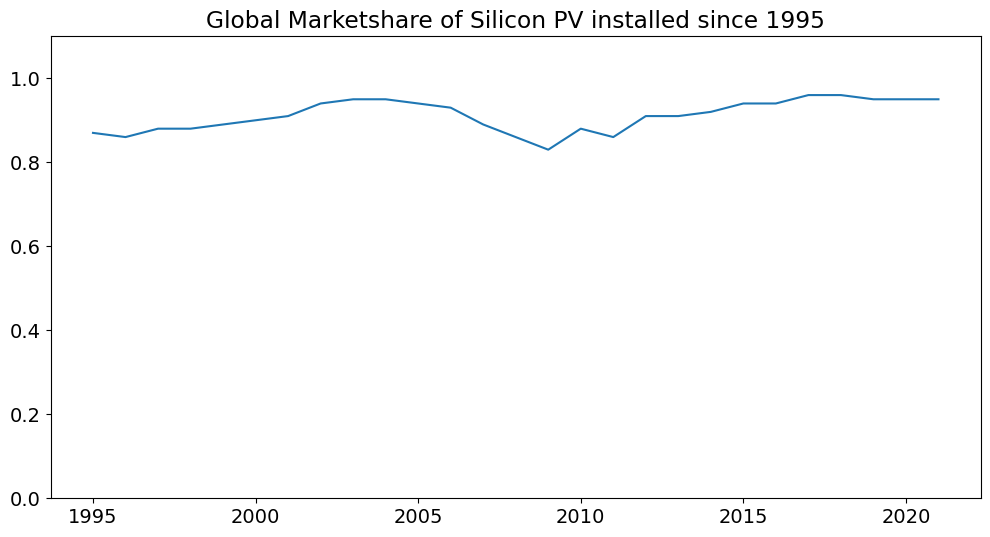

In [13]:
#convert to decimal
mrktshr_global_pct = mrktshr_global/100

plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(mrktshr_global_pct)
plt.title('Global Marketshare of Silicon PV installed since 1995')
plt.ylim(0,1.1)

# Marketshare weight PV installs by percent Silicon
Now we have a marketshare percentage of silicon for 1995 through 2019. We will multiply the PV installs by this silicon marketshare to get the MW of silicon PV installed globally since 1995.

In [ ]:
#put the two dataframes together, joining for available data (excludes NANs)
dfs = [installs,mrktshr_global_pct]
df = pd.concat(dfs, axis=1, join='inner')
df_clean = df.dropna()
#creates the marketshare weighted c-Si install data
world_si_installs = df_clean.agg('prod', axis='columns') 

#print(us_si_installs)
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (15, 8)
plt.plot(installs, label='All Global PV Installed', color='orange')
plt.plot(world_si_installs, label='Silicon PV Installed, World', color='blue')
plt.yscale('log')
plt.title('Silicon PV Installations (MW) Globally, 1995 through 2019')
plt.legend()

In [ ]:
world_si_installs.to_csv(cwd+'/../../PV_ICE/baselines/SupportingMaterial/output_Global_SiPV_installs.csv', index=True)

This data only takes installs through 2019. For the remaining years through 2050, a compound annual growth rate of 8.9% was used to predict increasing installations. This compound annual growth rate was sourced from IRENA 2016 EoL Mangement Report and IRENA 2019 Future of PV Report.

# Global Installations by Country

This section documents and munges the IRENA world historical PV install data by country. We can then modify it by the world marketshare of silicon.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
cwd = os.getcwd() #grabs current working directory

supportMatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')


In [2]:
IRENA_raw_file = os.path.join(supportMatfolder, 'HistoricalCapacityWorld-QueryResult-PVCumCap.xlsx') #THIS IS CUMULATIVE
IRENA_global_raw = pd.read_excel(IRENA_raw_file, header=7, index_col=0) #set Country/area as index
#remove the flag indicator columns or any unnamed
IRENA_global_raw.drop(columns=list(IRENA_global_raw.filter(like='Unnamed')), inplace=True) 
IRENA_global_raw.drop(columns=['Technology','Indicator'], inplace=True) #drop these columns

In [3]:
IRENA_locs = list(IRENA_global_raw.index)
regions = ['Africa','Asia','C America + Carib','Eurasia','Europe','EU 27','Middle East','N America','Oceania','S America']
countries = [i for i in IRENA_locs if i not in regions] #leaves in world

In [4]:
IRENA_global = IRENA_global_raw.T

In [5]:
shiftpos = IRENA_global.shift(1).fillna(0)

In [6]:
IRENA_global_annual = IRENA_global-shiftpos

In [7]:
IRENA_regions = IRENA_global_annual.loc[:,regions]
IRENA_countries = IRENA_global_annual.loc[:,countries]

In [8]:
IRENA_regions.to_csv(path_or_buf=os.path.join(supportMatfolder, 'output-RegionInstalls-alltech.csv'))
IRENA_countries.to_csv(path_or_buf=os.path.join(supportMatfolder, 'output-CountryInstalls-alltech.csv'))

## Market Share Weight Global installs by Silicon

In [14]:
mrktshr_global.index[-1] #what is the last year we have data for?

2021

In [15]:
#trim the c-Si marketshare to match index of IRENA installs
mrktshr_cSiglobal_IRENA = mrktshr_global.loc[mrktshr_global.index>1999]/100 #turn into decimal

In [16]:
mrktshr_cSiglobal_IRENA.columns

Index(['Global_MarketShare'], dtype='object')

In [17]:
IRENA_regions_cSi = IRENA_regions.multiply(mrktshr_cSiglobal_IRENA["Global_MarketShare"], axis="index")
IRENA_countries_cSi = IRENA_countries.multiply(mrktshr_cSiglobal_IRENA["Global_MarketShare"], axis="index")

In [18]:
IRENA_regions_cSi.to_csv(path_or_buf=os.path.join(supportMatfolder, 'output-RegionInstalls-cSi.csv'))
IRENA_countries_cSi.to_csv(path_or_buf=os.path.join(supportMatfolder, 'output-CountryInstalls-cSi.csv'))

In [ ]:
#access the global historical install and create projection
IRENA_hist_cSi = pd.read_csv(os.path.join(supportMatfolder,'output-CountryInstalls-cSi.csv'), index_col=0)

In [ ]:
IRENA_hist_cSi_world = pd.DataFrame(IRENA_hist_cSi['World']) #extract just the global historical installs (this is a series)

In [ ]:
#create a full historical deployment + projection 
# 2050 needs cumulative of 14,036 GW of PV globally [World Energy Transitions Outlook: 1.5°C Pathway.IRENA; 2021]
#https://irena.org/Statistics/View-Data-by-Topic/Energy-Transition/REmap-Energy-Generation-and-Capacity
idx = pd.RangeIndex(start=2018,stop=2051,step=1) #create the index
IRENA_world_cSi_project = pd.DataFrame(index=idx, columns=['World_cum'], dtype=float) #turn into df and add column to match other series
IRENA_world_cSi_project.loc[2018]=481*1000 #MW in 2018
IRENA_world_cSi_project.loc[2050]=14036*1000 #MW in 2050

In [ ]:
# exponential interpolation option - not great
# Import curve fitting package from scipy
from scipy.optimize import curve_fit
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)
#generae a dataset for the area in between
y_dummy = power_law(IRENA_world_cSi_project.index-2017, IRENA_world_cSi_project['World_cum'][2018], 0.965)
#played around with the exponential until y_dummy[31] closely matched 14036 GW.
print(y_dummy[32])
plt.plot(y_dummy)
#plt.plot(IRENA_world_cSi_project['World_cum'][2050], marker='o')

In [ ]:
IRENA_world_cSi_project['World_cum_fill']=y_dummy
IRENA_world_cSi_project.loc[2050]

In [ ]:
#IRENA_world_cSi_project.interpolate(inplace=True) #create the cumulative global deployed pv each year (linear also not great)
IRENA_world_cSi_project['World'] = IRENA_world_cSi_project['World_cum_fill']-IRENA_world_cSi_project['World_cum_fill'].shift(1).fillna(0)

In [ ]:
IRENA_world_cSi_project_annual_torev = IRENA_world_cSi_project.loc[2022:2050,['World']]
IRENA_world_cSi_project_annual = IRENA_world_cSi_project_annual_torev.iloc[::-1] #reverse the exponential to be more realistic
IRENA_world_cSi_project_annual.index = IRENA_world_cSi_project_annual_torev.index #reset index related to above

In [ ]:
IRENA_cSi_world = pd.concat([IRENA_hist_cSi_world,IRENA_world_cSi_project_annual])
#IRENA_cSi_world

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(IRENA_cSi_world)
plt.title('PV Installation Globally')
plt.ylabel('Annually Deployed PV [MWdc]')